### Dependencies:

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import format_number, when, col, array, udf, lit
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.types import *


In [2]:
dataset = pd.read_csv(r"Crimes_-_2001_to_Present.csv")
dataset

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,12.0,61.0,08B,1165074.0,1875917.0,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,29.0,25.0,06,1138875.0,1904869.0,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)"
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,8.0,44.0,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,35.0,21.0,18,1152037.0,1920384.0,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,28.0,25.0,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7796922,12936285,JF526139,06/27/2022 10:05:00 AM,025XX N HALSTED ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,...,43.0,7.0,11,1170513.0,1917030.0,2022,01/03/2023 03:46:28 PM,41.927817,-87.648846,"(41.927817456, -87.648845932)"
7796923,12936301,JF526810,12/22/2022 06:00:00 PM,020XX W CORNELIA AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,32.0,5.0,14,1161968.0,1923233.0,2022,01/03/2023 03:46:28 PM,41.945022,-87.680072,"(41.945021752, -87.680071764)"
7796924,12936397,JF526745,12/19/2022 02:00:00 PM,044XX N ROCKWELL ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,...,47.0,4.0,05,1158237.0,1929586.0,2022,01/03/2023 03:46:28 PM,41.962532,-87.693611,"(41.962531969, -87.693611152)"
7796925,12935341,JF525383,12/20/2022 06:45:00 AM,027XX W ROOSEVELT RD,0810,THEFT,OVER $500,STREET,False,False,...,28.0,29.0,06,1158071.0,1894595.0,2022,01/03/2023 03:46:28 PM,41.866517,-87.695179,"(41.866517317, -87.695178701)"


### 1. Only select data that after 2009.
### 2. Drop some crimes that are not important or have low data points.

In [3]:
dataset = dataset[(dataset['Year'] > 2009)]
dataset = dataset[(dataset['Primary Type'] != 'STALKING') &
                  (dataset['Primary Type'] != 'OBSCENITY') &
                  (dataset['Primary Type'] != 'NON-CRIMINAL (SUBJECT SPECIFIED)') &
                  (dataset['Primary Type'] != 'GAMBLING') &
                  (dataset['Primary Type'] != 'NON - CRIMINAL') &
                  (dataset['Primary Type'] != 'LIQUOR LAW VIOLATION') &
                  (dataset['Primary Type'] != 'PUBLIC INDECENCY') &
                  (dataset['Primary Type'] != 'HUMAN TRAFFICKING') &
                  (dataset['Primary Type'] != 'INTIMIDATION') &
                  (dataset['Primary Type'] != 'CONCEALED CARRY LICENSE VIOLATION') &
                  (dataset['Primary Type'] != 'NON-CRIMINAL') &
                  (dataset['Primary Type'] != 'OTHER NARCOTIC VIOLATION')]
dataset.shape

(3703402, 22)

### Extract Day, Month, WeekDay, Hour from Date column:

In [4]:
# Splitting the Date column and extracting the Day
dataset['Day'] = dataset['Date'].str.split(" ").str[0]

# Converting the Day to date format
dataset['Day'] = pd.to_datetime(dataset['Day'], format="%m/%d/%Y")

# Extracting the Month from the Day
dataset['Month'] = dataset['Day'].dt.month

# Extracting the WeekDay from the Day
dataset['WeekDay'] = dataset['Day'].dt.dayofweek + 1  # Adding 1 to match PySpark's dayofweek function

# Splitting the Date column and extracting the Hour
dataset['Hour'] = dataset['Date'].str.split(" ").str[1].str.split(":").str[0].astype(int)

# Dropping rows with any missing values
dataset = dataset.dropna()
dataset.shape

(3655486, 26)

### Merge similar crime types to make the data more balance:

In [5]:
dataset.loc[dataset['Primary Type'].isin(['CRIM SEXUAL ASSAULT', 'PROSTITUTION']), 'Primary Type'] = 'SEX OFFENSE'
dataset.loc[dataset['Primary Type'].isin(['WEAPONS VIOLATION', 'INTERFERENCE WITH PUBLIC OFFICER']), 'Primary Type'] = 'PUBLIC PEACE VIOLATION'
dataset.loc[dataset['Primary Type'] == 'ARSON', 'Primary Type'] = 'CRIMINAL TRESPASS'

### Check the number of crimes after merge:


In [6]:
dataset.groupby('Primary Type')['Date'].count().reset_index().sort_values(by='Date', ascending=False)


,Primary Type,Date
17,THEFT,816690
1,BATTERY,672375
3,CRIMINAL DAMAGE,401316
10,NARCOTICS,271662
0,ASSAULT,259026
12,OTHER OFFENSE,225238
6,DECEPTIVE PRACTICE,199025
2,BURGLARY,195231
9,MOTOR VEHICLE THEFT,180657
15,ROBBERY,142270


### Check the number of crimes using bar chart:


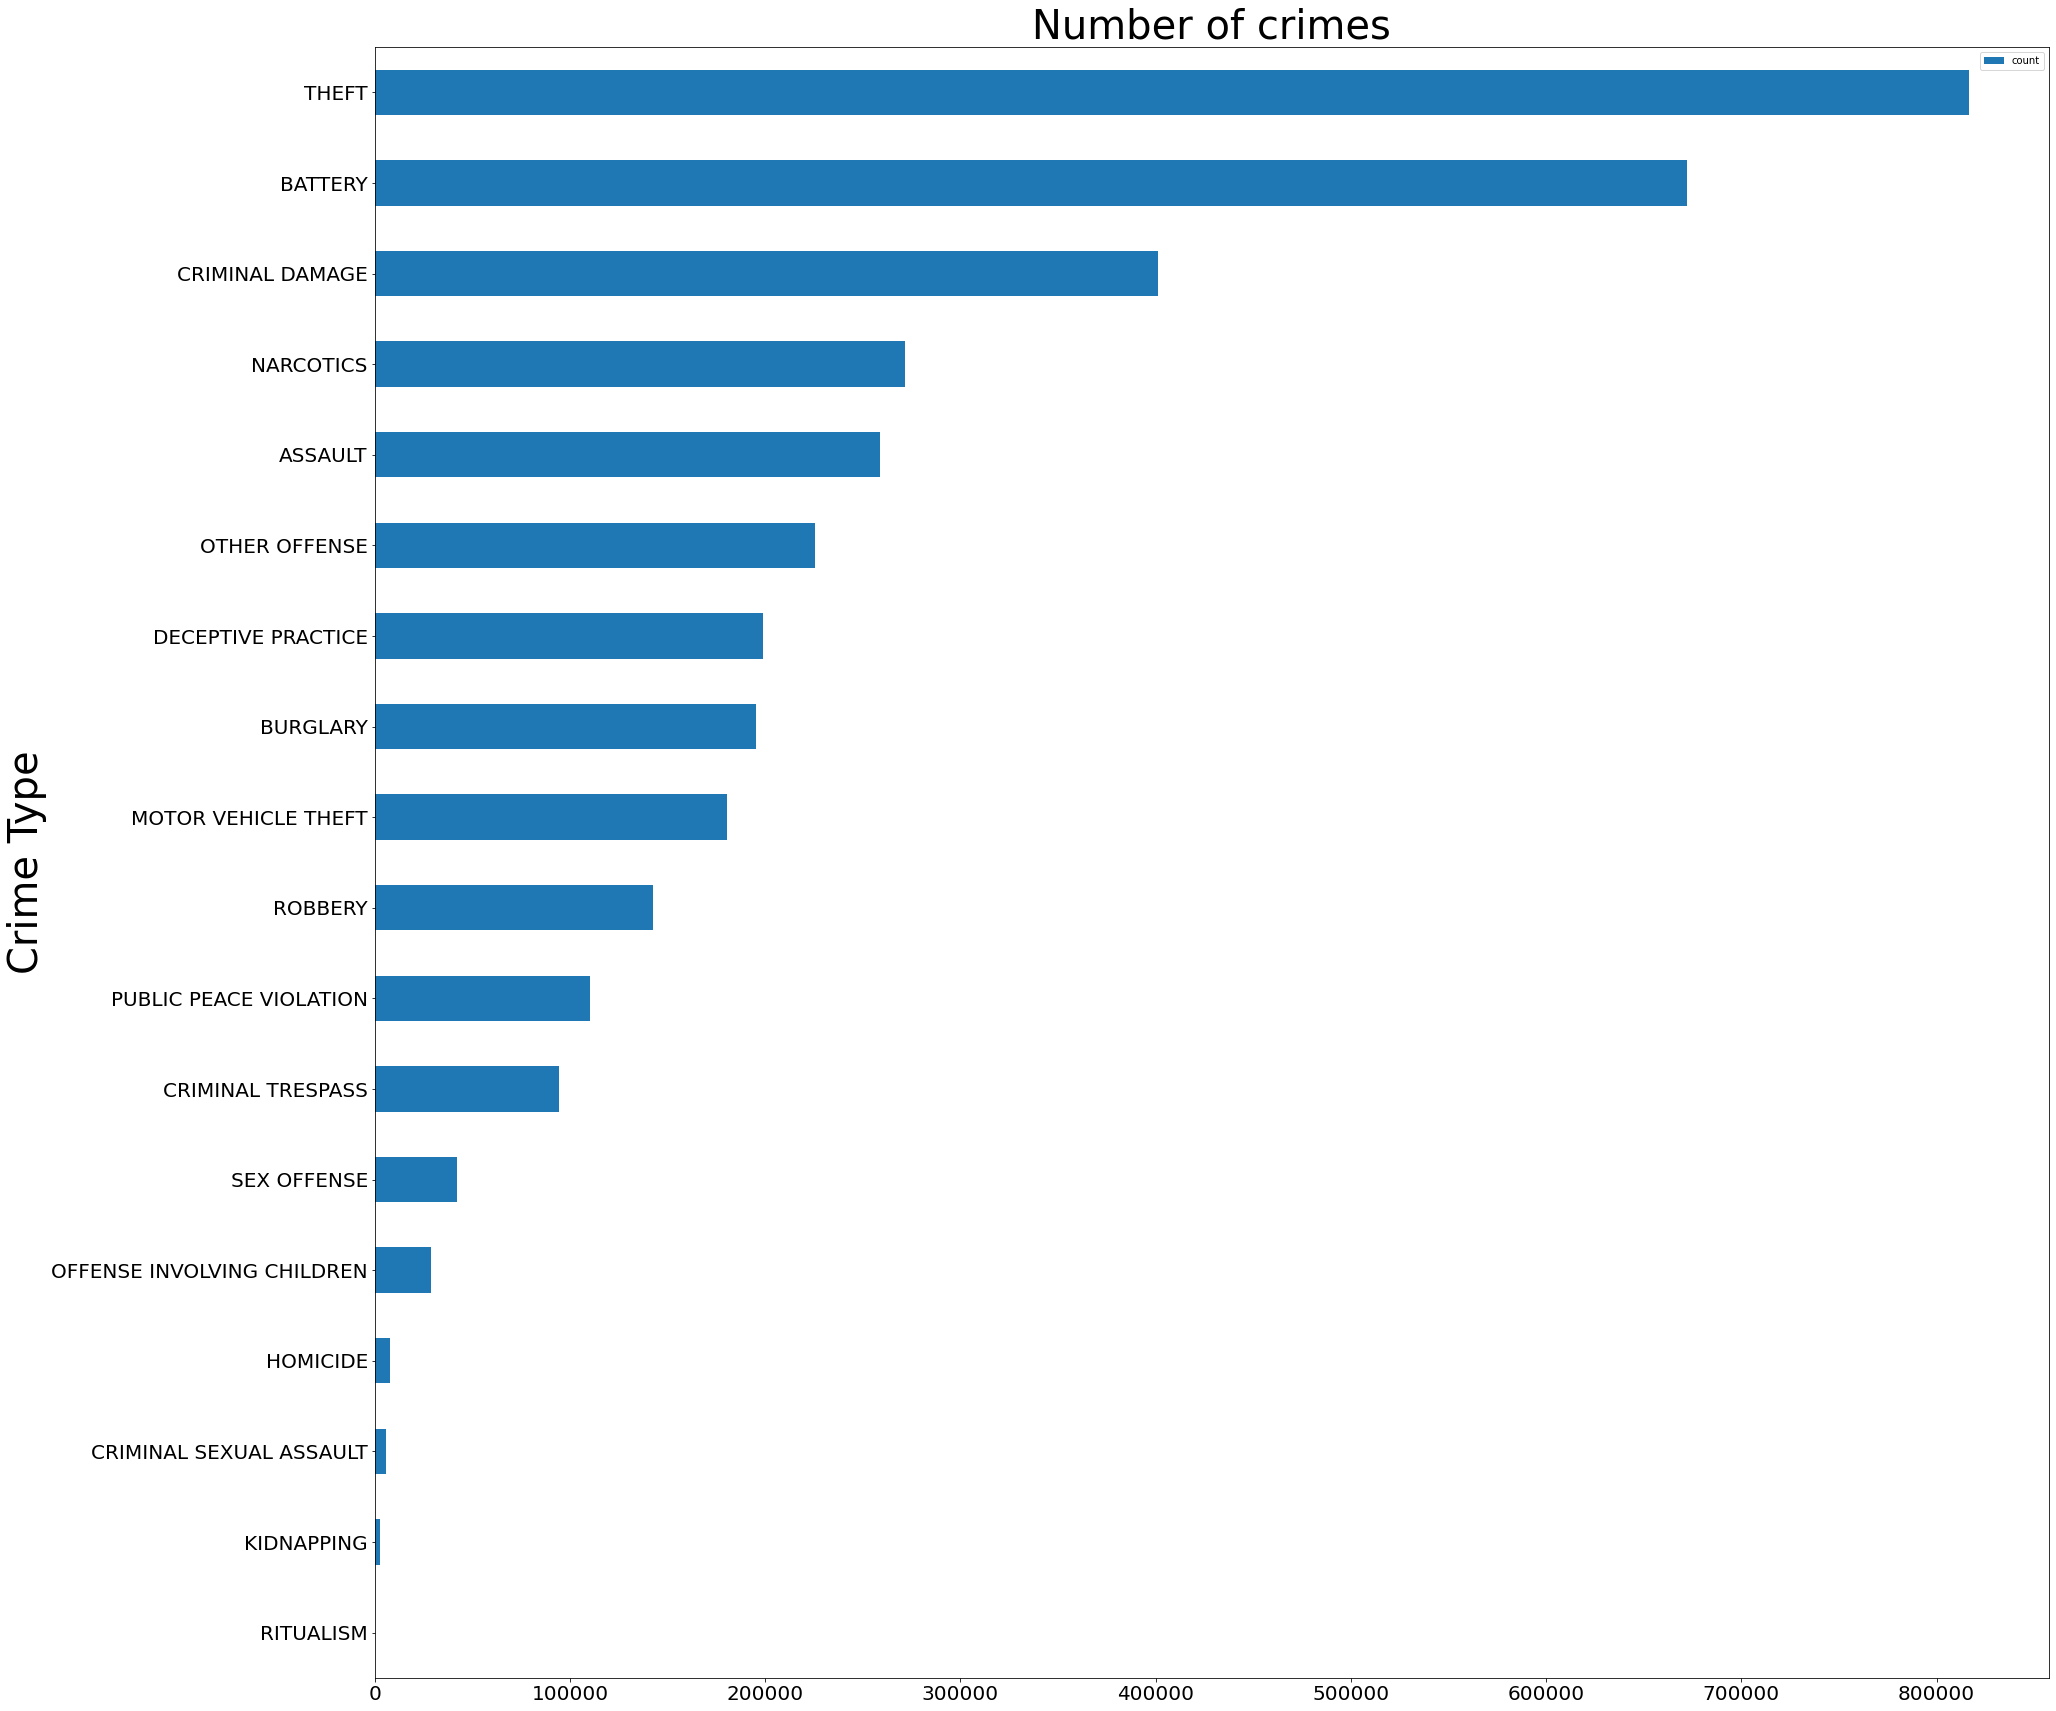

In [7]:
grouped_data = dataset.groupby("Primary Type").size().reset_index(name='count')

# Sorting the data by the count column
sorted_data = grouped_data.sort_values(by='count')

# Creating a horizontal bar plot
sorted_data.plot(x='Primary Type', y='count', kind='barh', figsize=(30, 30), fontsize=20)

# Adding title and labels to the plot
plt.title("Number of crimes", fontsize=40)
plt.ylabel('Crime Type', fontsize=40)

# Displaying the plot
plt.show()


### List top 10 blocks that have most crimes:

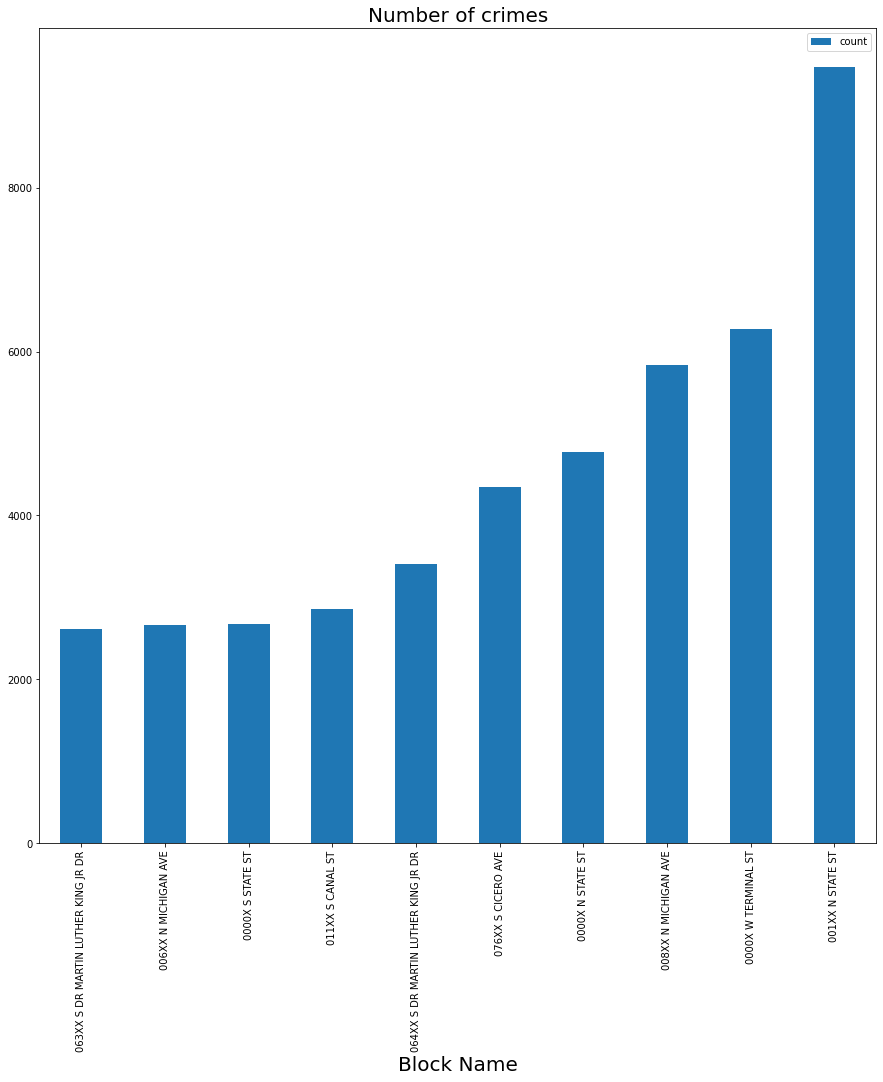

In [8]:
# Grouping the dataset by "Block" and counting the occurrences
grouped_data = dataset.groupby("Block").size().reset_index(name='count')

# Sorting the data by the count column
sorted_data = grouped_data.sort_values(by='count')

# Selecting the top 10 rows based on count
top_10_data = sorted_data.tail(10)

# Creating a bar plot
top_10_data.plot(x='Block', y='count', kind='bar', figsize=(15, 15), fontsize=10)

# Adding title and labels to the plot
plt.title("Number of crimes", fontsize=20)
plt.xlabel('Block Name', fontsize=20)

# Displaying the plot
plt.show()

### Using head map to check hot spot of crimes.
#### #Make sure you have the folium library installed before running the code. This code will create a folium Map object centered at the specified latitude and longitude. It will then extract latitude and longitude coordinates from the selected subset of the dataset and generate a HeatMap layer based on those coordinates. Finally, it will display the heatmap. Adjust the code according to your dataset structure and column names if necessary.
### From heat map we can see that crimes have cluster pattern, so that we have the possibility to predict it.

In [9]:
# Specify the latitude and longitude for the center of the map
latitude = 41.864073157
longitude = -87.706818608

# Create a folium Map object
heatMap = folium.Map(location=[latitude, longitude], tiles="OpenStreetMap", zoom_start=12)

# Select a subset of the dataset for heatmap visualization (e.g., first 20,000 rows)
hotspot = dataset.head(20000)

# Extract the latitude and longitude coordinates from the selected subset
heat_data = [[row['Latitude'], row['Longitude']] for index, row in hotspot.iterrows()]

# Create a HeatMap layer and add it to the map
HeatMap(heat_data, radius=10).add_to(heatMap)

# Display the heatmap
heatMap



### The following we will use Random Forest algorithm to train and test the model:
### Only use "Latitude" and "Longitude" as features:

In [10]:
spark = SparkSession.builder.appName("Project - Chicago crime").config("spark.some.config.option", "some-value").config("spark.driver.memory", "8g").config("spark.driver.cores", "3").getOrCreate()


In [11]:
vector_assembler = VectorAssembler(inputCols = ["Latitude", "Longitude"], outputCol="features")

In [12]:
dataset.to_csv('dataset.csv',index=False)

In [13]:
dataset =spark.read.option("header", "True").option("inferSchema", "true").csv("dataset.csv")

In [14]:
df_temp = vector_assembler.transform(dataset)
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)

In [15]:
labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=100,impurity='gini', maxBins=128)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)


In [16]:
predictions = model.transform(testData)
predictions.select("predictedLabel", "Primary Type").show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")

+--------------+-------------------+
|predictedLabel|       Primary Type|
+--------------+-------------------+
|       BATTERY|           BURGLARY|
|       BATTERY|            BATTERY|
|         THEFT|            ROBBERY|
|       BATTERY|            ASSAULT|
|       BATTERY|            ROBBERY|
|       BATTERY|            ROBBERY|
|       BATTERY|    CRIMINAL DAMAGE|
|         THEFT|            BATTERY|
|         THEFT|              THEFT|
|       BATTERY|            BATTERY|
|         THEFT|            BATTERY|
|       BATTERY|MOTOR VEHICLE THEFT|
|       BATTERY|            BATTERY|
|       BATTERY|            BATTERY|
|         THEFT|        SEX OFFENSE|
|       BATTERY|           BURGLARY|
|       BATTERY|            ASSAULT|
|         THEFT|    CRIMINAL DAMAGE|
|       BATTERY|      OTHER OFFENSE|
|       BATTERY|              THEFT|
+--------------+-------------------+
only showing top 20 rows



In [17]:
accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)


print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

accuracy = 0.258391
f1 score = 0.168191
+--------------+------+
|predictedLabel| count|
+--------------+------+
|         THEFT|470048|
|       BATTERY|533958|
|     NARCOTICS| 93397|
+--------------+------+



In [18]:
dataset.count(), dataset.limit(5).toPandas().head()

(3655486,
          ID Case Number                    Date                Block  IUCR  \
 0  10224738    HY411648  09/05/2015 01:30:00 PM      043XX S WOOD ST  0486   
 1  10224739    HY411615  09/04/2015 11:30:00 AM  008XX N CENTRAL AVE  0870   
 2  10224740    HY411595  09/05/2015 12:45:00 PM    035XX W BARRY AVE  2023   
 3  10224741    HY411610  09/05/2015 01:00:00 PM  0000X N LARAMIE AVE  0560   
 4  10224742    HY411435  09/05/2015 10:55:00 AM  082XX S LOOMIS BLVD  0610   
 
   Primary Type              Description Location Description  Arrest  \
 0      BATTERY  DOMESTIC BATTERY SIMPLE            RESIDENCE   False   
 1        THEFT           POCKET-PICKING              CTA BUS   False   
 2    NARCOTICS    POSS: HEROIN(BRN/TAN)             SIDEWALK    True   
 3      ASSAULT                   SIMPLE            APARTMENT   False   
 4     BURGLARY           FORCIBLE ENTRY            RESIDENCE   False   
 
    Domestic  ...  Y Coordinate  Year              Updated On   Latitude  

In [19]:
dataset=dataset.na.drop()
dataset.count()

3655486

### Use all the availble features: "Latitude", "Longitude", "Arrest", "Beat", "Ward","WeekDay","Hour"

In [20]:
vector_assembler = VectorAssembler(inputCols = ["Latitude", "Longitude", "Arrest", "Beat", "Ward","WeekDay","Hour"], outputCol="features")
df_temp = vector_assembler.transform(dataset)
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)


labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10,impurity='gini', maxBins=32)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)


In [21]:
predictions = model.transform(testData)
predictions.select("predictedLabel", "Primary Type").show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")


+--------------+--------------------+
|predictedLabel|        Primary Type|
+--------------+--------------------+
|         THEFT|             BATTERY|
|         THEFT|     CRIMINAL DAMAGE|
|       BATTERY|       OTHER OFFENSE|
|     NARCOTICS|PUBLIC PEACE VIOL...|
|         THEFT|            BURGLARY|
|     NARCOTICS|               THEFT|
|     NARCOTICS|           NARCOTICS|
|         THEFT|             ASSAULT|
|       BATTERY|             BATTERY|
|         THEFT|             BATTERY|
|     NARCOTICS|     CRIMINAL DAMAGE|
|     NARCOTICS|           NARCOTICS|
|       BATTERY|         SEX OFFENSE|
|     NARCOTICS|PUBLIC PEACE VIOL...|
|     NARCOTICS|           NARCOTICS|
|         THEFT|             BATTERY|
|         THEFT|     CRIMINAL DAMAGE|
|       BATTERY| MOTOR VEHICLE THEFT|
|       BATTERY|             ASSAULT|
|         THEFT|     CRIMINAL DAMAGE|
+--------------+--------------------+
only showing top 20 rows



In [22]:
accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)


print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

accuracy = 0.297378
f1 score = 0.189319
+--------------+------+
|predictedLabel| count|
+--------------+------+
|         THEFT|527439|
|       BATTERY|344930|
|     NARCOTICS|224153|
+--------------+------+



### Encoding "Location description":

In [23]:
from pyspark.ml.feature import OneHotEncoder
locationIndexer = StringIndexer(inputCol="Location Description", outputCol="indexedLocation")\
                .fit(dataset)\
                .transform(dataset)
encoded_data = OneHotEncoder(inputCols=["indexedLocation"],outputCols=["encodedLocation"])\
        .fit(locationIndexer)\
        .transform(locationIndexer)

In [24]:
vector_assembler = VectorAssembler(inputCols = ["Latitude", "Longitude", "Arrest", "Beat", "Ward","Community Area","WeekDay","Hour","encodedLocation"], outputCol="features")
df_temp = vector_assembler.transform(encoded_data)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)


labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10,impurity='gini', maxBins=32)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)


In [25]:
predictions = model.transform(testData)
predictions.select("predictedLabel", "Primary Type").show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")

+--------------+--------------------+
|predictedLabel|        Primary Type|
+--------------+--------------------+
|         THEFT|             BATTERY|
|       BATTERY|             BATTERY|
|       BATTERY|            BURGLARY|
|         THEFT| MOTOR VEHICLE THEFT|
|         THEFT|             ROBBERY|
|         THEFT|           NARCOTICS|
|         THEFT|PUBLIC PEACE VIOL...|
|       BATTERY|             BATTERY|
|       BATTERY|     CRIMINAL DAMAGE|
|         THEFT|               THEFT|
|         THEFT|             BATTERY|
|         THEFT|             BATTERY|
|       BATTERY|             ASSAULT|
|         THEFT|         SEX OFFENSE|
|       BATTERY|            BURGLARY|
|         THEFT|       OTHER OFFENSE|
|       BATTERY|             BATTERY|
|         THEFT|  DECEPTIVE PRACTICE|
|         THEFT|               THEFT|
|         THEFT|     CRIMINAL DAMAGE|
+--------------+--------------------+
only showing top 20 rows



In [26]:
accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)


print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

accuracy = 0.297912
f1 score = 0.193897
+------------------+------+
|    predictedLabel| count|
+------------------+------+
|             THEFT|848202|
|           BATTERY|204893|
|DECEPTIVE PRACTICE|  2176|
|         NARCOTICS| 41417|
+------------------+------+



### Using a grid search, 4-fold cross validation, and change to pipeline runner, finally get the best parameter:

In [27]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

vector_assembler = VectorAssembler(inputCols = ["Latitude", \
                            "Longitude", "Arrest", "Beat", "Ward","Community Area","WeekDay","Hour","encodedLocation"], outputCol="features")


indexed_data = vector_assembler.transform(encoded_data)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(indexed_data)


labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(indexed_data)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


(trainingData, testData) = indexed_data.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

paramGrid = ParamGridBuilder()\
            .addGrid(rf.numTrees, [3,10])\
            .addGrid(rf.maxBins, [32,64])\
            .addGrid(rf.maxDepth, [5,10])\
            .addGrid(rf.impurity,['gini','entropy'])\
            .build()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

crossval = CrossValidator(\
                          estimator=pipeline,\
                         estimatorParamMaps=paramGrid,\
                         evaluator=evaluator,\
                         numFolds=4)


model = crossval.fit(trainingData)


In [28]:
predictions = model.transform(testData)
predictions.select("predictedLabel", "Primary Type").show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")

evaluator3 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")

evaluator4 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall")



+--------------+--------------------+
|predictedLabel|        Primary Type|
+--------------+--------------------+
|         THEFT|       OTHER OFFENSE|
|     NARCOTICS|               THEFT|
|         THEFT| MOTOR VEHICLE THEFT|
|     NARCOTICS|PUBLIC PEACE VIOL...|
|       BATTERY|             BATTERY|
|       BATTERY|             ASSAULT|
|     NARCOTICS|   CRIMINAL TRESPASS|
|       BATTERY|   CRIMINAL TRESPASS|
|       BATTERY|             BATTERY|
|         THEFT|               THEFT|
|         THEFT|   CRIMINAL TRESPASS|
|     NARCOTICS|           NARCOTICS|
|       BATTERY|             ASSAULT|
|         THEFT|     CRIMINAL DAMAGE|
|     NARCOTICS|             BATTERY|
|     NARCOTICS|            BURGLARY|
|         THEFT|               THEFT|
|         THEFT|  DECEPTIVE PRACTICE|
|         THEFT|               THEFT|
|         THEFT|             ASSAULT|
+--------------+--------------------+
only showing top 20 rows



In [29]:
accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)
precision = evaluator3.evaluate(predictions)
recall = evaluator4.evaluate(predictions)


print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))
print("precision = %g" % (precision))
print("recall = %g" % (recall))

predictions.groupBy("predictedLabel").count().show()

accuracy = 0.347941
f1 score = 0.229068
precision = 0.233643
recall = 0.347941
+------------------+------+
|    predictedLabel| count|
+------------------+------+
|             THEFT|575278|
|           BATTERY|354162|
|DECEPTIVE PRACTICE|  3539|
|         NARCOTICS|161737|
|          BURGLARY|  1374|
+------------------+------+



Based on the provided accuracy, F1 score, precision, and recall values, we can make the following observations about the model's performance:

Accuracy (0.347941): The accuracy of 0.347941 indicates that approximately 34.794% of the instances were correctly predicted by the model. While accuracy is a commonly used metric, it's important to consider the class distribution and the specific requirements of the problem. In cases where class imbalance exists or the cost of misclassifications varies across classes, accuracy alone may not provide a comprehensive evaluation of the model.

F1 Score (0.229068): The F1 score is a measure that combines precision and recall, providing an overall evaluation of the model's performance. With an F1 score of 0.229068, it suggests that the model's precision and recall are relatively low. A low F1 score implies that the model struggles to balance between correctly identifying positive instances (precision) and capturing all positive instances (recall).

Precision (0.233643): Precision measures the proportion of true positive predictions out of all positive predictions made by the model. A precision value of 0.233643 indicates that the model has a low ability to make accurate positive predictions. It implies that a significant portion of the predicted positive instances may be false positives.

Recall (0.347941): Recall, also known as sensitivity or true positive rate, measures the proportion of true positive predictions out of all actual positive instances. A recall value of 0.347941 suggests that the model has a relatively higher ability to identify positive instances. However, the balance between precision and recall seems to favor recall over precision.

Overall, based on these metrics, the model's performance appears to be suboptimal. It may struggle to accurately predict positive instances (low precision) while capturing all positive instances (low recall). It's advisable to further investigate the model, consider the data quality, feature engineering, and potentially explore other algorithms or techniques to improve its performance. Additionally, domain-specific considerations and other evaluation metrics may provide further insights into the model's effectiveness.